# 역전파의 구현과 확률적 경사하강법 구현

In [6]:
import matplotlib.pyplot as plt
import numpy as np

저번 시간에 구현했던 MNIST 데이터셋은 다음과 같습니다.

In [7]:
import os, cv2
class mnist_dataset():
    def __init__(self, path):
        data_list = []
        for label in range(10):
            label_path = os.path.join(path, str(label))
            file_list = os.listdir(label_path)
            data_list += [[os.path.join(label_path, file), label] for file in file_list]
        self.data_list = data_list
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, i):
        png_path, label = self.data_list[i]
        img_loaded = cv2.imread(png_path, cv2.IMREAD_GRAYSCALE)
        return img_loaded.reshape(-1)/255, label
training_dataset = mnist_dataset('../mnist_png/training/')
test_dataset = mnist_dataset('../mnist_png/training/')

이를 이용해 배치를 생성하는 클래스 dataloader를 다음과 구현합니다.     
dataloader는 임의의 dataset을 입력으로 받아 배치들을 생성해 주는 함수입니다.

In [8]:
x = np.arange(10)
np.random.shuffle(x)
print(x)

[1 5 0 2 4 9 3 6 7 8]


In [9]:
class dataloader():
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size=batch_size
        self.index = np.arange(len(dataset))
        self.shuffle()
        
    def __len__(self):
        return len(self.dataset) // self.batch_size
        
    def __getitem__(self, i):
        result = []
        for j in range(self.batch_size*i, self.batch_size*(i+1)):
            result.append(self.dataset[self.index[j]])
        return result
    
    def shuffle(self):
        np.random.shuffle(self.index)

In [10]:
training_dataloader = dataloader(training_dataset, 16)

In [11]:
training_dataloader[0][0][1]

7

In [12]:
len(training_dataloader)

3750

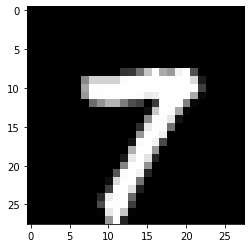

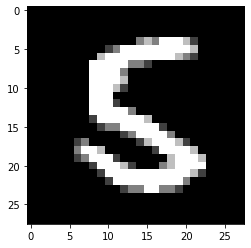

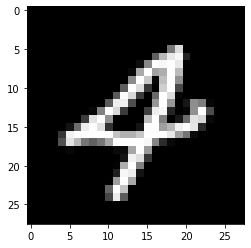

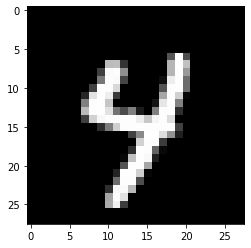

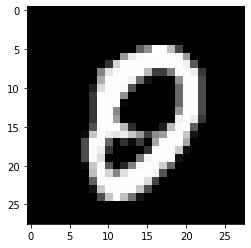

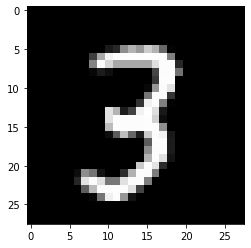

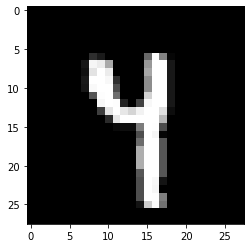

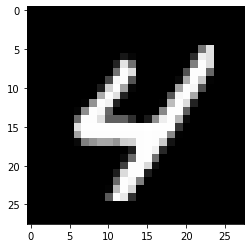

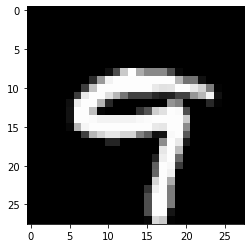

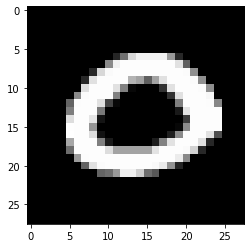

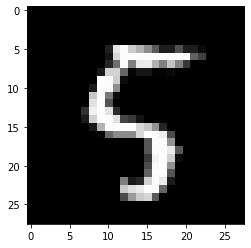

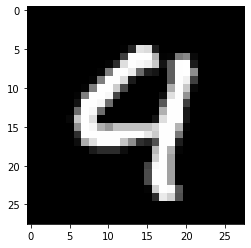

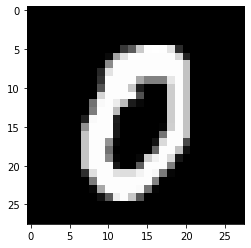

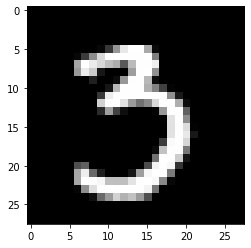

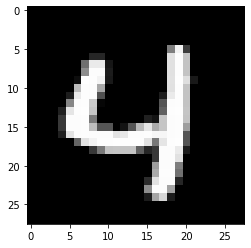

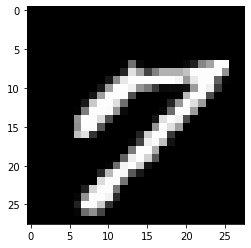

In [13]:
for img, label in training_dataloader[0]:
    plt.imshow(img.reshape((28,28)),cmap='gray')
    plt.show()

저번 시간에 구현했던 MLP 네트워크와 각종 함수들은 다음과 같습니다

In [14]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def ReLU(x):
    return x * (x > 0)

def no_activation(x):
    return x

def softmax(z):
    y = z- np.max(z)
    return np.exp(y) / np.sum(np.exp(y))

def cross_entropy_loss(y, y_hat):
    return np.sum( -y * np.log(y_hat+1.e-8))

In [15]:
class MLP_Network:
    def __init__(self, sizes, activation_function = ReLU, last_activation = no_activation):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y) for y in sizes[1:]]
        self.weights = []
        for i in range(self.num_layers-1):
            self.weights.append(np.random.randn(self.sizes[i+1], self.sizes[i]))
        self.activation_function = ReLU
        self.last_activation = last_activation
        
    def forward(self, a):
        for i, [bias, weight] in enumerate(zip(self.biases, self.weights)):
            if i == self.num_layers - 2:
                activation = self.last_activation
            else:
                activation = self.activation_function
            a = activation(np.dot(weight, a)+bias)
            
        return a
    
    def accuracy(self,dataset):
        num_correct = 0
        for i, [img, label] in enumerate(dataset):
            y = eye[label]
            y_hat = self.forward(img.reshape(-1))
            if np.argmax(y_hat) == label:
                num_correct += 1
        print(f'Accuracy is {num_correct/len(dataset)}' )

In [16]:
net = MLP_Network([2, 3, 6, 4, 10, 10], activation_function = sigmoid)
output = net.forward(np.random.randn((2)))
print(output)
print(np.sum(output))

net = MLP_Network([2, 3, 6, 4, 10, 10], activation_function = sigmoid, last_activation = softmax)
output = net.forward(np.random.randn((2)))
print(output)
print(np.sum(output))

[-2.15215632  5.56581392 -4.04381027  6.38868134  4.95391986 -3.15982341
  3.76804833  6.90888721 -0.64321024  1.88697541]
19.47332582092715
[9.28866320e-03 2.67042509e-02 1.52811700e-01 2.29690571e-01
 7.82326992e-02 1.43198445e-02 4.47981172e-04 2.80504098e-02
 8.99739310e-03 4.51456487e-01]
1.0


역전파의 구현의 편의를 위해 활성화 함수는 ReLU로 마지막 활성화 함수는 소프트맥스로 고정한 후 구현합니다.

In [17]:
class MLP_Network:
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y) for y in sizes[1:]]
        self.weights = []
        for i in range(self.num_layers-1):
            self.weights.append(np.random.randn(self.sizes[i+1], self.sizes[i]))
        self.activation_function = ReLU
        self.last_activation = softmax
    def forward(self, a):
        for i, [bias, weight] in enumerate(zip(self.biases, self.weights)):
            if i == self.num_layers - 2:
                activation = self.last_activation
            else:
                activation = self.activation_function
            a = activation(np.dot(weight, a)+bias)
            
        return a
    
    def accuracy(self, dataset):
        num_correct = 0
        for i, [img, label] in enumerate(dataset):
            y = eye[label]
            y_hat = self.forward(img.reshape(-1))
            if np.argmax(y_hat) == label:
                num_correct += 1
        print(f'Accuracy is {num_correct/len(dataset)}' )

이제 역전파를 위한 함수를 구현합니다.    
수업시간에 다뤘던 대로 $\frac{\partial C}{\partial a^{L}}$를 계산해야 합니다.    
수업시간에는 L2 손실함수를 사용하였기 때문에 $\frac{\partial C}{\partial a^{L}} = -(y-x)$였습니다.    
하지만 교차 엔트로피 함수를 손실함수로 사용하면 이 미분값도 다시 계산해야 합니다.

마지막 $L$층에서의 출력값은 $a^L = softmax(z^L)$가 되고 이를 교차 엔트로피 손실함수에 입력하면 $C = \sum ^n _{i=1} -y_{i}\textrm{log}(a^L_i)$가 됩니다.     
 $\frac{\partial C}{\partial z^{L}}$을 계산하면 $y_i=1$인 $i$에 대해 $\frac{\partial C}{\partial z^{L}} = a^L_i - y_i$를 얻을 수 있습니다.

먼저 역전파 진행하는데 앞서 순전파를 진행하여 필요한 $z^l$과 $a^l$를 계산합니다.

In [18]:
def backward(self, x, y):
    y = self.eye[y]       # y 를 one-hot vector 로 만듦
    self.grad_bs = [ np.zeros(b.shape) for b in self.biases ]
    self.grad_ws = [ np.zeros(w.shape) for w in self.weights ]
    a_s = [x]
    z_s = []
    a = x
    for i, [bias, weight] in enumerate(zip(self.biases, self.weights)):
        if i == self.num_layers - 2:
            activation = self.last_activation
        else:
            activation = self.activation_function
        z = np.dot(weight, a)+bias
        z_s.append(z)
        a = activation(z)
        a_s.append(a)
    # forward 를 진행하면서 activation 이전, 이후 결과값 저장
    grad_zs = [ np.zeros(b.shape) for b in self.biases ] 
    # 마지막 성분 = a[-1] - y[-1]
    # l 번째 성분 = grad_as[l] * sigmoid'(z_s[l])
    
    grad_as = [ np.zeros(b.shape) for b in self.biases ] 
    # l 번째 성분 = np.matmul( np.transpose(self.ws[l+1]), grad_zs[l+1] )
    grad_zs[-1] = a_s[-1] - y
    for l in range(2, self.num_layers):
        grad_as[-l] = np.matmul( np.transpose(self.ws[-l+1]), grad_zs[-l+1] )
        grad_zs[-l] = grad_as[-l] * sigmoid(z_s[-l])*(1-sigmoid(z_s[-l]))
    
    for l in range(1,self.num_layers+1):
        grad_ws[-l] = np.matmul(grad_zs[-l].reshape([-1,1]), a_s[-l-1].reshape([1,-1]) )
        grad_bs[-l] = grad_zs[-l]

    return [grad_bs, grad_ws]

In [19]:
def backward(self, x, y):
    y = self.eye[y]
    grad_bs = [np.zeros(b.shape) for b in self.biases]
    grad_ws = [np.zeros(w.shape) for w in self.weights]
    z_s = []
    a_s = [x]
    a = x
    for i, [bias, weight] in enumerate(zip(self.biases, self.weights)):
        if i == self.num_layers - 2:
            activation = self.last_activation
        else:
            activation = self.activation_function
        z = np.matmul(weight, a)+bias
        a = activation(z)
        z_s.append(z)
        a_s.append(a)
        
    dz = a_s[-1] - y 
    grad_bs[-1] = dz
    grad_ws[-1] = np.matmul(dz.reshape(-1, 1), a_s[-2].reshape(1, -1))
    for l in range(2, self.num_layers):
        z = z_s[-l]
        dz = np.matmul(self.weights[-l+1].transpose(), dz) * self.ReLU_prime(z)
        grad_bs[-l] = dz
        grad_ws[-l] = np.matmul(dz.reshape(-1,1), a_s[-l-1].reshape(1,-1))
    return [grad_bs, grad_ws]

    
def ReLU_prime(self, z):
    return (z>0).astype(np.int)



각각의 $(x_i, y_i)$ 대해 경사를 계산 후 이를 배치 전체의 데이터에 대해 더해 전체 경사를 계산합니다.

In [20]:
def grad_mini_batch(self, batch):
    sum_grad_b = [np.zeros(b.shape) for b in self.biases]
    sum_grad_w = [np.zeros(w.shape) for w in self.weights]
    for x, y in batch:
        grad_bs, grad_ws = self.backward(x,y)
        for i in range(len(grad_bs)):
            sum_grad_bs[i] = sum_grad_bs[i] + grad_bs[i]
        for i in range(len(grad_ws)):
            sum_grad_ws[i] = sum_grad_ws[i] + grad_ws[i]
            
    return sum_grad_b, sum_grad_w

이를 이용해 배치와 학습률 $\lambda$를 입력으로 받아 파라미터를 업데이트하는 함수를 구현합니다.

In [21]:
def update_mini_batch(self, batch, lambda_):
    n = len(batch)
    sum_grad_b, sum_grad_w = self.grad_mini_batch(batch)
    for i in range(len(self.ws)):
        self.ws[i] = self.ws[i] - lambda_*sum_grad_w[i]/n
    for i in range(len(self.bs)):
        self.bs[i] = self.bs[i] - lambda_*sum_grad_b[i]/n

배치에 대해 계산한 경사를 이용해 확률적 경사 하강법을 다음과 같이 구현합니다.

In [22]:
def SGD(self, dataset, epochs, batch_size, lambda_):
    training_dataloader = dataloader(dataset, batch_size)
    for epoch in range(epochs):
        training_dataloader.shuffle()
        for batch in trainind_dataloader:
            self.update_mini_batch(batch, lambda_)
        self.accuracy(dataset)

지금까지 구현한 메소드들과 결과를 통합하여 하나의 클래스로 만들어줍니다.

In [23]:
from tqdm.notebook import tqdm

In [24]:
class MLP_Network:
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y) for y in sizes[1:]]
        self.weights = []
        for i in range(self.num_layers-1):
            self.weights.append(np.random.randn(self.sizes[i+1], self.sizes[i]))
        self.activation_function = ReLU
        self.last_activation = softmax
        self.eye = np.eye(sizes[-1])
    def forward(self, a):
        for i, [bias, weight] in enumerate(zip(self.biases, self.weights)):
            if i == self.num_layers - 2:
                activation = self.last_activation
            else:
                activation = self.activation_function
            a = activation(np.matmul(weight, a)+bias)
        return a
    
    def accuracy(self,dataset):
        num_correct = 0
        for i, [img, label] in enumerate(dataset):
            y = self.eye[label]
            y_hat = self.forward(img)
            if np.argmax(y_hat) == label:
                num_correct += 1
        print(f'Accuracy is {num_correct/len(dataset)}' )
        
    def ReLU_prime(self, z):
        return (z>0).astype(np.int)
        
    def backward(self, x, y):
        y = self.eye[y]       # y 를 one-hot vector 로 만듦
        grad_bs = [ np.zeros(b.shape) for b in self.biases ]
        grad_ws = [ np.zeros(w.shape) for w in self.weights ]
        a_s = [x]
        z_s = []
        a = x
        for i, [bias, weight] in enumerate(zip(self.biases, self.weights)):
            if i == self.num_layers - 2:
                activation = self.last_activation
            else:
                activation = self.activation_function
            z = np.dot(weight, a)+bias
            z_s.append(z)
            a = activation(z)
            a_s.append(a)
        # forward 를 진행하면서 activation 이전, 이후 결과값 저장
        grad_zs = [ np.zeros(b.shape) for b in self.biases ] 
        # 마지막 성분 = a[-1] - y[-1]
        # l 번째 성분 = grad_as[l] * sigmoid'(z_s[l])

        grad_as = [ np.zeros(b.shape) for b in self.biases ] 
        # l 번째 성분 = np.matmul( np.transpose(self.weights[l+1]), grad_zs[l+1] )
        grad_zs[-1] = a_s[-1] - y
        for l in range(2, self.num_layers):
            grad_as[-l] = np.matmul( np.transpose(self.weights[-l+1]), grad_zs[-l+1] )
            grad_zs[-l] = grad_as[-l] * sigmoid(z_s[-l])*(1-sigmoid(z_s[-l]))
            
#             * self.ReLU_prime(z_s[-l])# 

        for l in range(1,self.num_layers):
            grad_ws[-l] = np.matmul(grad_zs[-l].reshape([-1,1]), a_s[-l-1].reshape([1,-1]) )
            grad_bs[-l] = grad_zs[-l]

        return [grad_bs, grad_ws]

    def grad_mini_batch(self, batch):
        sum_grad_b = [np.zeros(b.shape) for b in self.biases]
        sum_grad_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in batch:
            grad_bs, grad_ws = self.backward(x,y)
            for i in range(len(grad_bs)):
                sum_grad_b[i] = sum_grad_b[i] + grad_bs[i]
            for i in range(len(grad_ws)):
                sum_grad_w[i] = sum_grad_w[i] + grad_ws[i]

        return sum_grad_b, sum_grad_w
    
    def update_mini_batch(self, batch, lambda_):
        n = len(batch)
        sum_grad_b, sum_grad_w = self.grad_mini_batch(batch)
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i] - lambda_*sum_grad_w[i]/n
        for i in range(len(self.biases)):
            self.biases[i] = self.biases[i] - lambda_*sum_grad_b[i]/n
    
    def SGD(self, dataset, epochs, batch_size, lambda_):
        training_dataloader = dataloader(dataset, batch_size)
        epoch_losses = []
        for epoch in range(epochs):
            loss = 0
            training_dataloader.shuffle()
            for batch in tqdm(training_dataloader):
                self.update_mini_batch(batch, lambda_)
                loss = loss + self.batch_loss(batch)
            epoch_losses.append(loss/len(training_dataloader))
            self.accuracy(dataset)
        return epoch_losses
    
    def batch_loss(self, batch):
        sum_loss = 0
        for img, label in batch:
            y = self.eye[label]
            y_hat = self.forward(img)
            sum_loss = sum_loss + cross_entropy_loss(y, y_hat)
        return sum_loss / len(batch)
    
    def loss(self, img, label):
        y = self.eye[label]
        y_hat = self.forward(img)
        loss = cross_entropy_loss(y, y_hat)
        return loss
    
    def loss_dataset(self, dataset):
        loss_sum = 0
        for i, [img, label] in enumerate(dataset):
            loss = self.loss(img, label)
            loss_sum += loss
        print(f'Loss is {loss_sum/len(dataset)}')
        return loss_sum/len(dataset)

In [27]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12298149530457983523
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4160159744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14318459719556864815
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [34]:
mlp_network = MLP_Network([784, 1000, 1000, 10])
losses = mlp_network.SGD(training_dataset, 30, 100, 0.001)

  0%|          | 0/600 [00:00<?, ?it/s]

c:\users\tjgus\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Accuracy is 0.82495


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.8548333333333333


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.8760833333333333


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.8900833333333333


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.8964333333333333


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.90145


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9092833333333333


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.89725


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9182166666666667


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.92


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9233666666666667


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9130833333333334


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9192333333333333


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.92985


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9261


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9359333333333333


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.93475


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.93025


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9369166666666666


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9360333333333334


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9421833333333334


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9419666666666666


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9334666666666667


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9418666666666666


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9453833333333334


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9410833333333334


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.94605


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9416


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9492833333333334


  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy is 0.9520833333333333


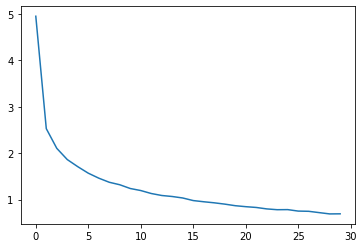

In [35]:
plt.plot(range(len(losses)), losses)
plt.show()